In [ ]:
#Google
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
# import scipy.optimize as optm
# import scipy.stats as ss
# from pmdarima.arima import auto_arima, ADFTest
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import optimizers
from sklearn.decomposition import PCA 
from keras.layers import SimpleRNN, Dense
from keras.layers import LSTM
import scipy.optimize as optm
import scipy.stats as ss
from keras.models import Sequential

In [ ]:
from dateutil.relativedelta import relativedelta
from pandas import Timestamp
import json
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from keras import regularizers

## 데이터 전처리

In [ ]:
#google
myfile_1 = '/content/drive/MyDrive/Colab Notebooks/data/raw_final.csv'

raw_data = pd.read_csv(myfile_1, index_col="Unnamed: 0")


In [ ]:
#MKT_DATA
myfile_2 = '/content/drive/MyDrive/Colab Notebooks/data/mkt_data.csv'

mkt_data = pd.read_csv(myfile_2)
mkt_data['Date'] = pd.to_datetime(mkt_data['Date'])
mkt_data.set_index('Date', inplace = True)

# risk free
myfile_3 = '/content/drive/MyDrive/Colab Notebooks/data/risk_free.xlsx'

tmp = pd.read_excel(myfile_3, index_col = 0)
rf = tmp.Close.mean()

In [ ]:
asset_col = raw_data.iloc[:,-3:].columns

raw_data[asset_col] = raw_data[asset_col].pct_change()

raw_data.dropna(inplace=True)

raw_data.index = pd.to_datetime(raw_data.index)

asset_spread = pd.DataFrame()
for i in range(len(asset_col)):
    for j in range(i+1, len(asset_col)):
        asset_spread[asset_col[i]+"-" + asset_col[j]] = raw_data[asset_col[i]] - raw_data[asset_col[j]]

## X, Y DATA

In [ ]:
# scaler = StandardScaler()

In [ ]:
X_data = raw_data.loc[:,~raw_data.columns.isin(asset_col)]

In [ ]:
Y_data = asset_spread.copy()

In [ ]:
X = X_data[:-1]
# X = scaler.fit_transform(X_data)[1:]
Y = Y_data.shift(-1).dropna()
# Y = scaler.fit_transform(data_m.iloc[:,-3:])[:-1]

## ML Model

In [ ]:
def dataset(data, label, window) :
    feature_array = []
    label_array = []
    for i in range(len(data) - window) :
        feature_array.append(np.array(data.iloc[i:i+window]))
        # y-label shift(-1) 해줬으므로 하나 앞으로 당겨줌
        label_array.append(np.array(label.iloc[i+window-1]))

    return np.array(feature_array), np.array(label_array)

In [ ]:
# return값 예측
def regress_RNN(X_tr, y_tr, X_ts, y_ts, epochs, learning_rate, n_hidden, n_neurons, drop_outs, input_shape): 

    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.3, random_state=42, shuffle =False)
    pca = PCA(n_components = 10)
    X_tr2 = pca.fit_transform(X_tr)
    X_ts2 = pca.fit_transform(X_ts)
    X_val2 = pca.fit_transform(X_val)

    RNN_x_tr, RNN_y_tr = dataset(pd.DataFrame(ss.zscore(X_tr2)), y_tr, 3)
    RNN_x_test, RNN_y_test = dataset(pd.DataFrame(ss.zscore(X_ts2)), y_ts, 3)
    RNN_x_val, RNN_y_val = dataset(pd.DataFrame(ss.zscore(X_val2)), y_val, 3)
    
    # activation
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(n_neurons, input_shape = (RNN_x_tr.shape[1], RNN_x_tr.shape[2]), return_sequences = False))

    for layer in range(n_hidden) :
      model.add(tf.keras.layers.Dense(n_neurons))
      model.add(tf.keras.layers.Dense(1))
      model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate))

    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    model_fit = model.fit(RNN_x_tr, RNN_y_tr, epochs = epochs, batch_size = 20, validation_split = 0.2, callbacks=[callback])
    model_eval = model.evaluate(RNN_x_val, RNN_y_val, return_dict=True)
  
    fig = plt.figure()
    plt.plot(model_fit.history['loss'], label='training loss')
    plt.plot(model_fit.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
      # #local
    #plt.savefig("./figure/regress/regress_RNN_"+str(X_ts.index[0]).split()[0]+"_output_1"+
    #              "_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".png")

      # plt.close(fig)
     
      #google
    #plt.savefig("/content/drive/MyDrive/Colab Notebooks/figure/classify/regress_RNN_"+str(X_ts.index[0]).split()[0]+"_output_1"
    #            +"_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".png")
    plt.close(fig)
    
    pred = model.predict(RNN_x_test).reshape(-1)

    pred_df = pd.DataFrame(pred, columns = y_ts.columns[:], index=y_ts.index[3:])
    
    return pred_df, model_eval

In [ ]:
# (X_tr, y_tr, X_ts, y_ts, epochs = 1, learning_rate=0.1, n_hidden = 3, n_neurons = 10, drop_outs=0.5, input_shape=107)
def main(classify_or_regress, one_or_multi, method, X, Y, epochs,learning_rate, n_hidden, n_neurons,
         drop_outs, input_shape):
    
    global raw_data

    Total_Q_df = pd.DataFrame()
    Total_Accuracy = pd.DataFrame()
    Total_Loss = pd.DataFrame()
      
    #for RNN
    start_point = X.index[3]
      
    add_3year = relativedelta(years=+3)
    add_1year = relativedelta(years=+1)
    subtract_3mon = relativedelta(months=-3)
  #     add_mon = relativedelta(months=+trading_period_months)
      
    while True:
        print(start_point)
          
        #Regress는 Raw Data에서 뽑아오기
        if classify_or_regress == "regress":
            Y = raw_data.iloc[:, -3:]

        if method == "NN":
            X_train = X.loc[start_point:start_point+add_3year]
            y_train = Y.loc[start_point:start_point+add_3year]
            X_test = X.loc[start_point+add_3year:start_point+add_3year+add_1year]
            y_test = Y.loc[start_point+add_3year:start_point+add_3year+add_1year]         
             
            X_train = X_train.astype('float32')
            y_train = y_train.astype('float32')
            X_test = X_test.astype('float32')
            y_test = y_test.astype('float32')
              
        elif (method == "RNN") | (method == "LSTM"):
            X_train = X.loc[start_point+subtract_3mon:start_point+add_3year+subtract_3mon]
            y_train = Y.loc[start_point+subtract_3mon:start_point+add_3year+subtract_3mon]
            X_test = X.loc[start_point+subtract_3mon+add_3year:start_point+add_3year+add_1year]
            y_test = Y.loc[start_point+subtract_3mon+add_3year:start_point+add_3year+add_1year]
            print(X_train.shape)
            print(X_test.shape)
          
        if classify_or_regress == "classify":
          
            if one_or_multi == "multi":
                Q_df, model_eval = classify_NN(one_or_multi, X_train , y_train,X_test, y_test, epochs, n_neurons, drop_outs, input_shape)

                Total_Q_df = pd.concat([Total_Q_df, Q_df])
                Total_Accuracy.loc[start_point+add_3year, "Accuracy"] = model_eval[1]
              
            elif one_or_multi == "one":
                  
                tmp_Q_df = pd.DataFrame()
                  
                for col in y_train.columns:
                    y_train_one = y_train[[col]]
                    y_test_one = y_test[[col]]
                      
                    Q_df, model_eval = classify_NN(one_or_multi, X_train , y_train_one,X_test, y_test_one, epochs, n_neurons, drop_outs, input_shape)
                    tmp_Q_df = pd.concat([tmp_Q_df, Q_df], axis =1)
                    Total_Accuracy.loc[start_point+add_3year, "Acc_"+col] = model_eval[1]
                      
                Total_Q_df = pd.concat([Total_Q_df, tmp_Q_df])
                  
                  
            else:
                print("one_or_multi")  
              
              
              
        elif classify_or_regress == "regress":
              
            if one_or_multi == "one":
                  
                tmp_pred_df = pd.DataFrame()
                tmp_Q_df = pd.DataFrame()
                  
                for col in y_train.columns:
                    y_train_one = y_train[[col]]
                    y_test_one = y_test[[col]]
                      
                    if method == "NN":
                        pred, model_eval = regress_NN(one_or_multi, X_train , y_train_one, X_test, y_test_one, epochs, n_neurons, drop_outs, input_shape)
                        # print(pred)
                        # print(model_eval)
                    elif method == "RNN":
                        pred, model_eval = regress_RNN(X_train, y_train_one, X_test, y_test_one, epochs,
                                                        learning_rate, n_hidden, n_neurons, drop_outs, input_shape)
                        # print(pred)
                        # print(model_eval)
                    elif method == "LSTM":
                        pred, model_eval = regress_LSTM(X_train , y_train_one,X_test, y_test_one, epochs)
                    else:
                        print("model need: NN RNN LSTM")

                    Total_Loss.loc[start_point+add_3year, "Loss_"+str(col)] = model_eval["loss"]

                      
                    tmp_pred_df = pd.concat([tmp_pred_df, pred], axis =1)
                      
                col_ls = tmp_pred_df.columns
                for i in range(len(col_ls)):
                    for j in range(i+1, len(col_ls)):
                        tmp_Q_df[col_ls[i]+"-" +col_ls[j]] = tmp_pred_df[col_ls[i]] - tmp_pred_df[col_ls[j]]           
                  
                Total_Q_df = pd.concat([Total_Q_df, tmp_Q_df])
                  
                  
            else:
                print("regress는 one만 가능")
          
        else:
            print("classify_or_regress")
              
          
        start_point = start_point + add_1year

        if(start_point+add_3year+add_1year>X.index[-1]):
            break
          
          # print(Total_Q_df)
      
    if classify_or_regress == "classify":
          # Total_Q_df.to_excel("./Q/classify/classify_"+method+"_output_"+str(one_or_multi)
          #         +"_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".xlsx")
          
        Total_Q_df.to_excel("/content/drive/MyDrive/Colab Notebooks/Q/classify/classify_"+method+"_output_"+str(one_or_multi)
        +"_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".xlsx")

        Total_Accuracy.to_excel("/content/drive/MyDrive/Colab Notebooks/performance/classifiy_"+method+"_output_"+str(one_or_multi)
        +"_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".xlsx")
      
    elif classify_or_regress == "regress":
          # Total_Q_df.to_excel("./Q/regress/regress_"+method+"_output_"+str(one_or_multi)
          #         +"_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".xlsx")
        Total_Q_df.to_excel("/content/drive/MyDrive/Colab Notebooks/Q/regress/regress_"+method+"_output_"+str(one_or_multi)
        +"_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".xlsx")

        Total_Loss.to_excel("/content/drive/MyDrive/Colab Notebooks/performance/regress_"+method+"_output_"+str(one_or_multi)
        +"_epochs_"+str(epochs)+"_lr_"+str(learning_rate)+"_nhidden_"+str(n_hidden)+"_nneurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".xlsx")
    

      # Total_Accuracy.to_excel("./performance/classifiy_"+method+"_output_"+str(one_or_multi)
      #             +"_epochs_"+str(epochs)+"_n_neurons_"+str(n_neurons)+"_dropout_"+str(drop_outs)+".xlsx")

    return Total_Q_df, Total_Loss
    

## BLM

In [ ]:
inv = np.linalg.inv

def get_mean_sigma(mkt_data):    
    return mkt_data.mean() * 100, (mkt_data*100).cov() * 252

def get_rskprt(data):
    return (1/data.std())/(1/data.std()).sum()

def blm_rvs_weight(mu_BL, big_sigma_BL, lamda):
    weight = 1/lamda*inv(big_sigma_BL)@mu_BL 
    return weight / weight.sum()

def op_func(w, geo_mean, big_sigma, rf, method='SR' , lamda=1, alpha=0.05):
    
    excess_return = w@(geo_mean - rf)
    std = np.sqrt(w.T@big_sigma@w)
    
    if method == 'VAR':
        eta = ss.norm.ppf(1-alpha)
        std = eta * np.sqrt(lamda * w.T@big_sigma@w) - excess_return
        
    elif method == 'CVAR':
        eta = ss.norm.ppf(1-alpha)
        std = ss.norm.pdf(eta)/(alpha) * np.sqrt(lamda * w.T@big_sigma@w) - excess_return
        
    else:
        std = np.sqrt(w.T@big_sigma@w)
        
    return - excess_return / std

cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }]
bnds = ( (0.00, 0.5), (0.00, 0.5), (0.00, 0.5) )

In [ ]:
def cal_bl_stat(mkt_data, Q, P, num) : 
    init_w = np.array([ 1/(len(asset_li)) ] * (len(asset_li)))
    #get_blm_mean_sigma(asset_w, Q, P, mkt_data, eta, mu_sigma, lamda=0):
    asset_w, Q, P, mkt_data, eta, mu_sigma, lamda = init_w, Q, P, mkt_data, [0.02]*len(asset_li), [0.02]*len(Q), 1
    geo_mean, big_sigma = get_mean_sigma(mkt_data)

    omega = np.zeros([len(Q),len(Q)])
    eq_sigma = np.zeros([len(asset_w),len(asset_w)]) 
    for i in range(len(Q)):
        #omega[i,i] = P[i,:].T@big_sigma@P[i,:] * (1-tau)
        omega[i,i] = mu_sigma[i]
    for i in range(len(asset_w)):
        eq_sigma[i,i] = eta[i]

    lamda = lamda if lamda != 0 else (asset_w@geo_mean - rf) / (asset_w.T@big_sigma@asset_w)

    big_pie = lamda * np.dot(big_sigma, asset_w.reshape((-1,1)))

    left_tmp = inv( inv(eq_sigma) + P.T @ inv(omega) @P )
    right_tmp = inv(eq_sigma) @ big_pie + P.T @ inv(omega) @ Q
    mu_BL = np.dot(left_tmp, right_tmp)

    big_sigma_BL = big_sigma + inv( inv(eq_sigma) + P.T @ inv(omega) @ P)

    blm_mu, blm_sigma, lamda = get_blm_mean_sigma(init_w, Q, P, mkt_data[test_date_list[num] : test_date_list[num+1]], [0.02]*len(asset_li), [0.02]*len(Q), 1)
    
    return (blm_mu, blm_sigma, lamda)

def cal_rolling_weight(asset_li, Q_df, P, mkt_data, num, start_date, end_date) :
    
    # Q shape 변경
    Q = np.array(Q_df)[num].reshape(-3,1)

    # bl_mu, sigma, lamda 계산
    (blm_mu, blm_sigma, lamda) = cal_bl_stat(mkt_data, Q, P, num)
    
    try_mkt_data = mkt_data[start_date : end_date]
    # 동일비중으로 시작
    # init_w = np.array([ 1/len(asset_li) ] * len(asset_li))

    # 모델별 weight 계산
    (init_w, rskprt_w, bl_w, sr_w) = cal_weight(asset_li, try_mkt_data, blm_mu, blm_sigma, lamda, rf)
    return (init_w, rskprt_w, bl_w, sr_w)

def cal_weight(asset_li, try_mkt_data, blm_mu, blm_sigma, lamda, rf) :
    init_w = np.array([ 1/(len(asset_li)) ] * (len(asset_li)))
    rskprt_w = np.array(get_rskprt(try_mkt_data))
    bl_w = blm_rvs_weight(blm_mu, blm_sigma,lamda).reshape(1,-1)
    sr_w = optm.minimize(op_func, x0=[ 1/len(init_w) ] * len(init_w), constraints=cons, bounds=bnds, args=(blm_mu, blm_sigma, rf, 'SR')).x
    return (init_w, rskprt_w, bl_w, sr_w)

def get_blm_mean_sigma(asset_w, Q, P, mkt_data, eta, mu_sigma, lamda=0):

    geo_mean, big_sigma = get_mean_sigma(mkt_data)
    
    omega = np.zeros([len(Q),len(Q)])
    eq_sigma = np.zeros([len(asset_w),len(asset_w)]) 
    for i in range(len(Q)):
        #omega[i,i] = P[i,:].T@big_sigma@P[i,:] * (1-tau)
        omega[i,i] = mu_sigma[i]
    for i in range(len(asset_w)):
        eq_sigma[i,i] = eta[i]
        
    lamda = lamda if lamda != 0 else (asset_w@geo_mean - rf) / (asset_w.T@big_sigma@asset_w)
    
    big_pie = lamda * np.dot(big_sigma, asset_w.reshape((-1,1)))

    left_tmp = inv( inv(eq_sigma) + P.T @ inv(omega) @P )
    right_tmp = inv(eq_sigma) @ big_pie + P.T @ inv(omega) @ Q
    mu_BL = np.dot(left_tmp, right_tmp)
    
    big_sigma_BL = big_sigma + inv( inv(eq_sigma) + P.T @ inv(omega) @ P)
    
    return mu_BL, big_sigma_BL, lamda

## Backtesting

In [ ]:
def get_none_P_Q(spread_df, asset_li) :
    # P, Q 빈 행렬 만들기
    row = 0
    # row의 갯수: 자산간 spread종류의 갯수 / column의 갯수: asset 종류의 갯수
    P = np.zeros((len(spread_df.columns), len(asset_li)))
    Q = np.zeros((len(spread_df.columns),1))
    for i in range(len(asset_li)):
        for j in range(i+1, len(asset_li)):
            P[row,i] = 1
            P[row,j] = -1
            row = row+1 
    return P, Q

In [ ]:
def get_model_weight(test_date_list, asset_li, Total_Q_df, P, mkt_data) :
    # 모델별 weight 뽑기
    init_w_list = []
    rskprt_w_list = []
    bl_w_list = []
    sr_w_list = []
    for num in range(len(test_date_list)-1) :
        # 날짜 설정
        start_date, end_date = test_date_list[num], test_date_list[num+1]
        (init_w, rskprt_w, bl_w, sr_w) = cal_rolling_weight(asset_li, Total_Q_df, P, mkt_data, num, start_date, end_date)
        init_w_list.append(init_w)
        rskprt_w_list.append(rskprt_w)
        bl_w_list.append(bl_w)
        sr_w_list.append(sr_w)
    return (init_w_list, rskprt_w_list, bl_w_list, sr_w_list)

In [ ]:
def get_mkt_ret(mkt_data, test_date_list) :
    start_value = 1
    mtk_ret = mkt_data.resample('1M').last().pct_change().shift(1).dropna()
    test_mkt_data = mtk_ret.reindex(test_date_list)
    test_mkt_data.iloc[0,:] = start_value
    return test_mkt_data

In [ ]:
def backtest(test_mkt_data, init_w_list, rskprt_w_list, bl_w_list, sr_w_list) :
    back_test = pd.DataFrame()
    back_test['Date'] = test_mkt_data.index.tolist()
    back_test['INIT'] = (np.array(test_mkt_data) * np.array(init_w_list)).sum(axis=1).tolist()
    back_test['RSKPRT'] = (np.array(test_mkt_data) * np.array(rskprt_w_list)).sum(axis=1).tolist()
    back_test['RVS'] = (np.array(test_mkt_data) * np.squeeze(bl_w_list)).sum(axis=1).tolist()
    back_test['SR'] = (np.array(test_mkt_data) * np.array(sr_w_list)).sum(axis=1).tolist()
    back_test.set_index('Date', inplace=True)
    back_test = back_test.fillna(0).cumsum()
    return back_test

In [ ]:
def final_backtest(Total_Q_df, mkt_data) : 

    # P,Q 빈행렬 구하기
    (P, Q) = get_none_P_Q(Total_Q_df, asset_li)

    # model별 weight list 구하기
    (init_w_list, rskprt_w_list, bl_w_list, sr_w_list) = get_model_weight(test_date_list, asset_li, Total_Q_df, P, mkt_data)


    # model weight 구하면서 가장 앞에 날짜 사라짐 그러므로 제거
    # test_mkt_data: 백테스트 수익률 위한 데이터프레임
    test_mkt_data = get_mkt_ret(mkt_data, test_date_list[1:])

    # 모델별 날짜 backtest cumsum 구하기
    back_test = backtest(test_mkt_data, init_w_list, rskprt_w_list, bl_w_list, sr_w_list)


    
    return back_test, rskprt_w_list, bl_w_list, sr_w_list

## RUN MODEL & BACKTEST!!!!!

In [ ]:
mse_list = []
parameter_list = []
learning_rate_list = [0.001, 0.005, 0.01]
n_hidden_list = [3, 5, 7]
n_neurons_list = [1, 3, 5]

for learning_rate in learning_rate_list :
  for n_hidden in n_hidden_list :
    for n_neurons in n_neurons_list :
      Total_Q_df,Total_loss_df = main("regress", "one","RNN", X[:60], Y[:60], 20, learning_rate, n_hidden, n_neurons, 0.5, 107)
      
      mse = Total_loss_df.sum(axis=1).sum() / len(Total_loss_df)
      mse_list.append(mse)

      paramter = "learning rate_" + str(learning_rate) + "_n_hidden_" + str(n_hidden) + "_n_neurons_" + str(n_neurons)

      parameter_list.append(paramter)

      print("#################"  + "learning rate_" + str(learning_rate) + "_n_hidden_" + str(n_hidden) + "_n_neurons_" + str(n_neurons) + "#######################")

2001-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0130 - val_loss: 0.0461
Epoch 2/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0125 - val_loss: 0.0443
Epoch 3/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0122 - val_loss: 0.0427
Epoch 4/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0119 - val_loss: 0.0415
Epoch 5/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0116 - val_loss: 0.0406
Epoch 6/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0114 - val_loss: 0.0400
Epoch 7/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0111 - val_loss: 0.0396
Epoch 8/20
1/1 [==============================] - 0s 400ms/step - loss: 0.0108 - val_loss: 0.0394
Epoch 9/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0105 - val_loss: 0.0392
Epoch 10/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0102 - val_los

In [ ]:
parameter_select = pd.DataFrame()

In [ ]:
parameter_select['parameter'] = parameter_list

In [ ]:
parameter_select['mse'] = mse_list

In [ ]:
parameter_select.sort_values(by = 'mse').to_csv('/content/drive/MyDrive/Colab Notebooks/data/hyper_parameter.csv')

# 새 섹션

In [ ]:
Y

,kospi-kosdaq,kospi-bond,kosdaq-bond
2001-02-28,0.013588,0.007751,-0.005837
2001-03-31,-0.050551,-0.028647,0.021904
2001-04-30,0.030136,0.017409,-0.012728
2001-05-31,0.027251,0.015550,-0.011701
2001-06-30,0.024188,0.013633,-0.010555
...,...,...,...
2020-05-31,0.004756,0.001237,-0.003519
2020-06-30,-0.037891,-0.009824,0.028067
2020-07-31,-0.006259,-0.001665,0.004594
2020-08-31,0.000846,0.000226,-0.000620


2001-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0079 - val_loss: 0.0152
Epoch 2/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0078 - val_loss: 0.0126
Epoch 3/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 4/20
1/1 [==============================] - 0s 72ms/step - loss: 0.0083 - val_loss: 0.0118
Epoch 5/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0073 - val_loss: 0.0153
Epoch 6/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0027


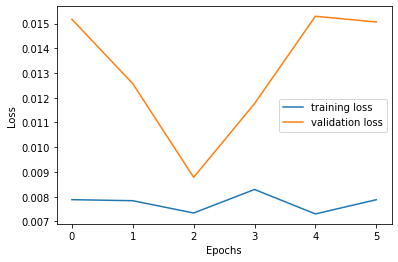

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 1.2646 - val_loss: 2.4106
Epoch 2/20
1/1 [==============================] - 0s 79ms/step - loss: 0.8401 - val_loss: 0.8477
Epoch 3/20
1/1 [==============================] - 0s 77ms/step - loss: 0.2791 - val_loss: 0.1964
Epoch 4/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0578 - val_loss: 0.0316
Epoch 5/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0400 - val_loss: 0.0290
Epoch 6/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0733 - val_loss: 0.0508
Epoch 7/20
1/1 [==============================] - 0s 75ms/step - loss: 0.0938 - val_loss: 0.0577
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0647


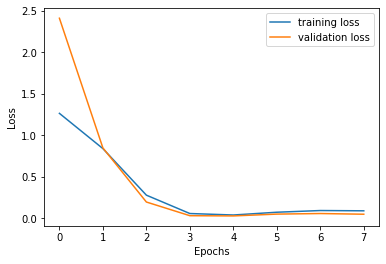

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0119 - val_loss: 0.0653
Epoch 2/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0393 - val_loss: 0.0200
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 4/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 5/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0220 - val_loss: 0.0115
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0099


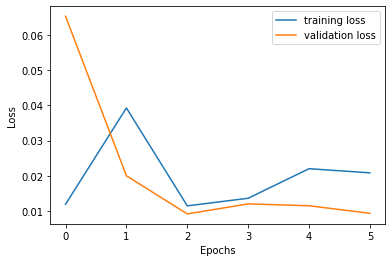

In [ ]:
# 재석
# (classify_or_regress, one_or_multi, method, X, Y, epochs,learning_rate, n_hidden, n_neurons, drop_outs, input_shape):
Total_Q_df,Total_loss_df = main("regress", "one","RNN", X[:60], Y[:60], 20, 0.05, 5, 1, 0.5, 107)

2001-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0182 - val_loss: 0.3523
Epoch 2/20
1/1 [==============================] - 0s 78ms/step - loss: 0.2869 - val_loss: 0.0326
Epoch 3/20
1/1 [==============================] - 0s 301ms/step - loss: 0.0164 - val_loss: 0.0248
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0439 - val_loss: 0.0684
Epoch 5/20
1/1 [==============================] - 0s 75ms/step - loss: 0.1012 - val_loss: 0.0653
Epoch 6/20
1/1 [==============================] - 0s 15ms/step - loss: 0.0664


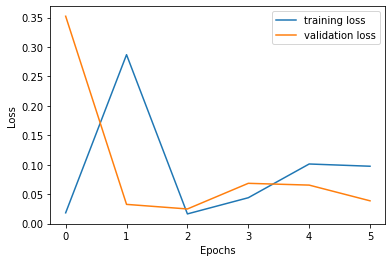

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0140 - val_loss: 0.0145
Epoch 2/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0248 - val_loss: 0.0127
Epoch 3/20
1/1 [==============================] - 0s 74ms/step - loss: 0.0145 - val_loss: 0.0203
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0156 - val_loss: 0.0259
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0059


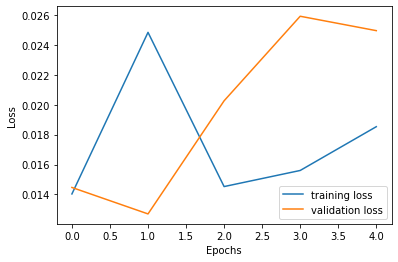

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0100 - val_loss: 0.0474
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0294 - val_loss: 0.0167
Epoch 3/20
1/1 [==============================] - 0s 76ms/step - loss: 0.0108 - val_loss: 0.0091
Epoch 4/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0130 - val_loss: 0.0103
Epoch 5/20
1/1 [==============================] - 0s 75ms/step - loss: 0.0179 - val_loss: 0.0096
Epoch 6/20
1/1 [==============================] - 0s 15ms/step - loss: 0.0054


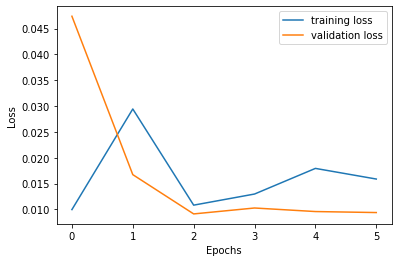

2002-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0055 - val_loss: 0.0346
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0258 - val_loss: 0.0084
Epoch 3/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 4/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 5/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0142 - val_loss: 0.0074
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0045


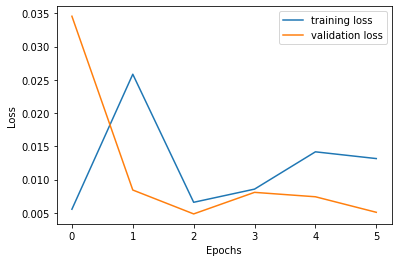

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0105 - val_loss: 0.0027
Epoch 2/20
1/1 [==============================] - 0s 295ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0102 - val_loss: 0.0020
Epoch 4/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0096 - val_loss: 0.0017
Epoch 5/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0097 - val_loss: 0.0018
Epoch 6/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0099 - val_loss: 0.0017
Epoch 7/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0130


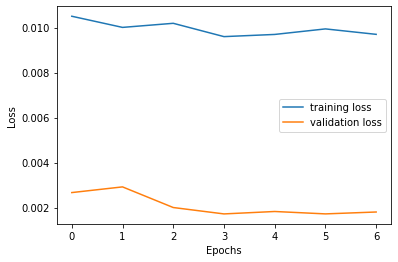

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0073 - val_loss: 0.1240
Epoch 2/20
1/1 [==============================] - 0s 96ms/step - loss: 0.1107 - val_loss: 0.0129
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 4/20
1/1 [==============================] - 0s 294ms/step - loss: 0.0211 - val_loss: 0.0342
Epoch 5/20
1/1 [==============================] - 0s 75ms/step - loss: 0.0475 - val_loss: 0.0314
Epoch 6/20
1/1 [==============================] - 0s 19ms/step - loss: 0.0169


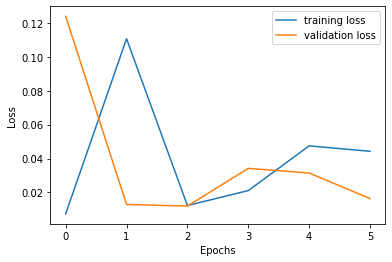

2003-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0508 - val_loss: 1.5539
Epoch 2/20
1/1 [==============================] - 0s 77ms/step - loss: 1.5176 - val_loss: 0.0985
Epoch 3/20
1/1 [==============================] - 0s 74ms/step - loss: 0.0906 - val_loss: 0.1210
Epoch 4/20
1/1 [==============================] - 0s 76ms/step - loss: 0.1396 - val_loss: 0.4194
Epoch 5/20
1/1 [==============================] - 0s 15ms/step - loss: 0.4263


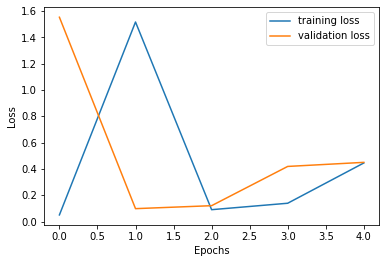

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.2219 - val_loss: 0.1662
Epoch 2/20
1/1 [==============================] - 0s 71ms/step - loss: 0.3562 - val_loss: 0.0276
Epoch 3/20
1/1 [==============================] - 0s 68ms/step - loss: 0.0326 - val_loss: 0.0838
Epoch 4/20
1/1 [==============================] - 0s 73ms/step - loss: 0.0305 - val_loss: 0.1496
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.1341


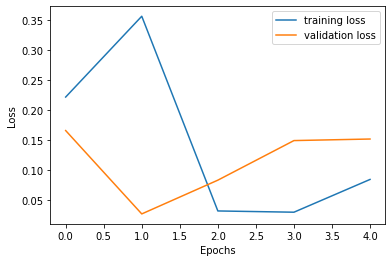

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0212 - val_loss: 0.2165
Epoch 2/20
1/1 [==============================] - 0s 74ms/step - loss: 0.3155 - val_loss: 0.0061
Epoch 3/20
1/1 [==============================] - 0s 72ms/step - loss: 0.0181 - val_loss: 0.0554
Epoch 4/20
1/1 [==============================] - 0s 75ms/step - loss: 0.0433 - val_loss: 0.1332
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.1391


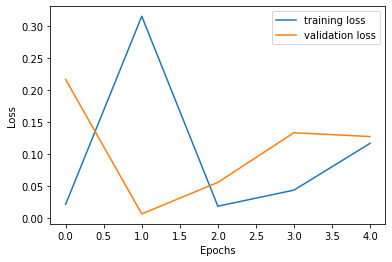

2004-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0036 - val_loss: 0.0477
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0646 - val_loss: 0.0049
Epoch 3/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0065 - val_loss: 0.0231
Epoch 4/20
1/1 [==============================] - 0s 298ms/step - loss: 0.0121 - val_loss: 0.0456
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0193


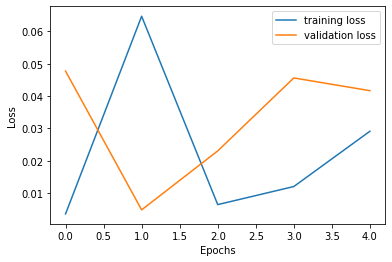

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0088 - val_loss: 0.0083
Epoch 2/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0131 - val_loss: 0.0097
Epoch 3/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0089 - val_loss: 0.0153
Epoch 4/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0026


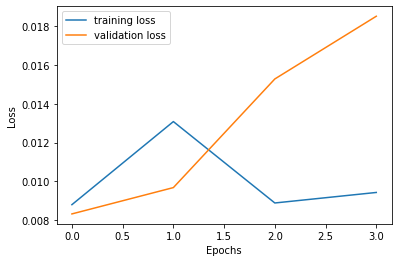

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0047 - val_loss: 0.0144
Epoch 2/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0222 - val_loss: 0.0050
Epoch 3/20
1/1 [==============================] - 0s 76ms/step - loss: 0.0052 - val_loss: 0.0127
Epoch 4/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0059 - val_loss: 0.0209
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0050


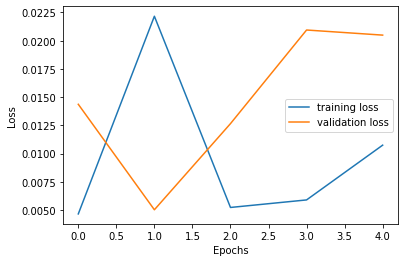

2005-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 1.6664 - val_loss: 0.7154
Epoch 2/20
1/1 [==============================] - 0s 79ms/step - loss: 0.7591 - val_loss: 0.1486
Epoch 3/20
1/1 [==============================] - 0s 307ms/step - loss: 0.1037 - val_loss: 0.0703
Epoch 4/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0481 - val_loss: 0.0780
Epoch 5/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0761 - val_loss: 0.0683
Epoch 6/20
1/1 [==============================] - 0s 98ms/step - loss: 0.0750 - val_loss: 0.0428
Epoch 7/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0512 - val_loss: 0.0178
Epoch 8/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0248 - val_loss: 0.0034
Epoch 9/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 10/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0037 - val_los

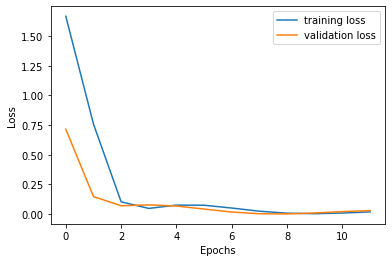

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0073 - val_loss: 0.0169
Epoch 2/20
1/1 [==============================] - 0s 304ms/step - loss: 0.0187 - val_loss: 0.0036
Epoch 3/20
1/1 [==============================] - 0s 90ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 4/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 5/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0103 - val_loss: 0.0040
Epoch 6/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0054


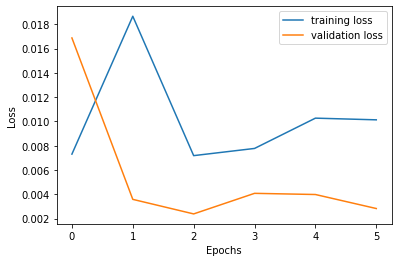

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.2898 - val_loss: 0.2117
Epoch 2/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0679 - val_loss: 0.0802
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0209 - val_loss: 0.0266
Epoch 4/20
1/1 [==============================] - 0s 295ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 5/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 6/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 7/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 8/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 9/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0066


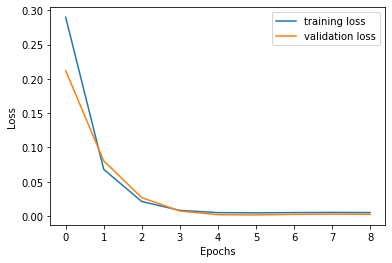

2006-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0026 - val_loss: 0.0233
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 3/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0028 - val_loss: 0.0058
Epoch 4/20
1/1 [==============================] - 0s 316ms/step - loss: 0.0035 - val_loss: 0.0059
Epoch 5/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 6/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 7/20
1/1 [==============================] - 0s 91ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0151


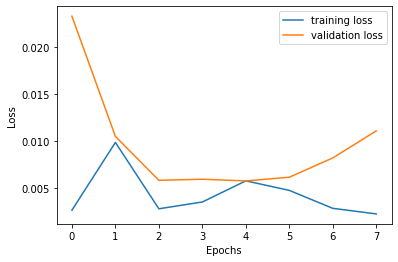

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0030 - val_loss: 0.0263
Epoch 2/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0119 - val_loss: 0.0098
Epoch 3/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 4/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 5/20
1/1 [==============================] - 0s 311ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 6/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 7/20
1/1 [==============================] - 0s 76ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 8/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0220


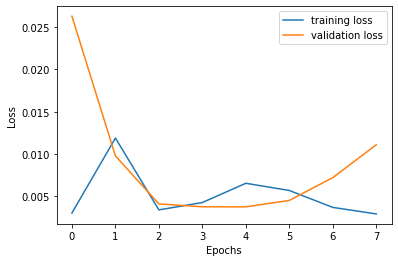

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0042 - val_loss: 0.0737
Epoch 2/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0481 - val_loss: 0.0149
Epoch 3/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 4/20
1/1 [==============================] - 0s 89ms/step - loss: 0.0083 - val_loss: 0.0122
Epoch 5/20
1/1 [==============================] - 0s 296ms/step - loss: 0.0197 - val_loss: 0.0113
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0082


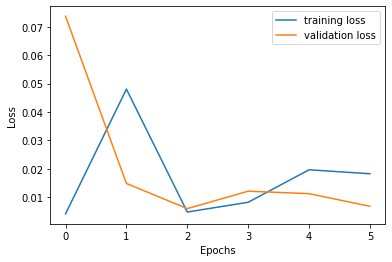

2007-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0049 - val_loss: 0.0526
Epoch 2/20
1/1 [==============================] - 0s 95ms/step - loss: 0.0322 - val_loss: 0.0166
Epoch 3/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 4/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0089 - val_loss: 0.0135
Epoch 5/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0161 - val_loss: 0.0124
Epoch 6/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0143 - val_loss: 0.0099
Epoch 7/20
1/1 [==============================] - 0s 314ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 8/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0054 - val_loss: 0.0158
Epoch 9/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0050


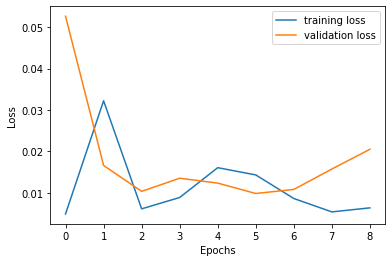

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - val_loss: 0.0350
Epoch 2/20
1/1 [==============================] - 0s 99ms/step - loss: 0.0263 - val_loss: 0.0208
Epoch 3/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0057 - val_loss: 0.0272
Epoch 4/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0085 - val_loss: 0.0341
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0077


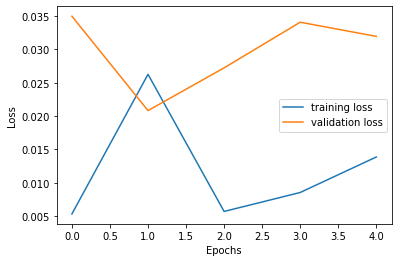

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.1927 - val_loss: 0.0739
Epoch 2/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0616 - val_loss: 0.0385
Epoch 3/20
1/1 [==============================] - 0s 75ms/step - loss: 0.0271 - val_loss: 0.0207
Epoch 4/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0132 - val_loss: 0.0146
Epoch 5/20
1/1 [==============================] - 0s 91ms/step - loss: 0.0076 - val_loss: 0.0143
Epoch 6/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0061 - val_loss: 0.0161
Epoch 7/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0063 - val_loss: 0.0176
Epoch 8/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0032


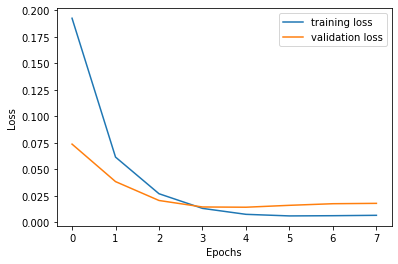

2008-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0100 - val_loss: 0.0689
Epoch 2/20
1/1 [==============================] - 0s 95ms/step - loss: 0.0565 - val_loss: 0.0092
Epoch 3/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0112 - val_loss: 0.0065
Epoch 4/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0126 - val_loss: 0.0188
Epoch 5/20
1/1 [==============================] - 0s 90ms/step - loss: 0.0253 - val_loss: 0.0197
Epoch 6/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0155


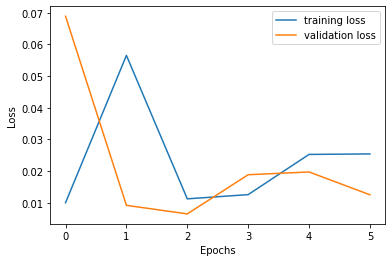

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0139 - val_loss: 0.0172
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 0.0244 - val_loss: 0.0040
Epoch 3/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0127 - val_loss: 0.0047
Epoch 4/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0140 - val_loss: 0.0069
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0047


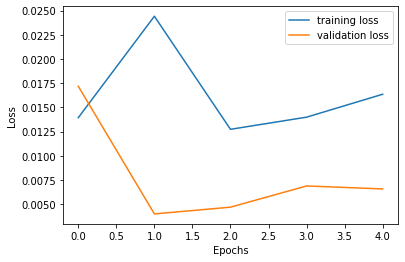

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0187 - val_loss: 0.1293
Epoch 2/20
1/1 [==============================] - 0s 89ms/step - loss: 0.0820 - val_loss: 0.0151
Epoch 3/20
1/1 [==============================] - 0s 301ms/step - loss: 0.0100 - val_loss: 0.0058
Epoch 4/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0131 - val_loss: 0.0199
Epoch 5/20
1/1 [==============================] - 0s 90ms/step - loss: 0.0295 - val_loss: 0.0229
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0128


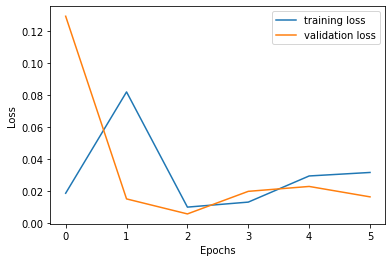

2009-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0035 - val_loss: 0.0474
Epoch 2/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0544 - val_loss: 0.0028
Epoch 3/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0057 - val_loss: 0.0096
Epoch 4/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0094 - val_loss: 0.0236
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0132


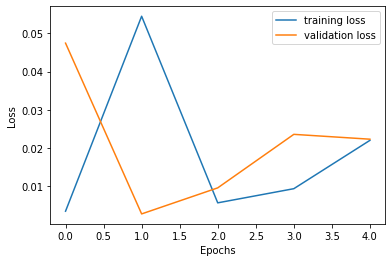

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0041 - val_loss: 0.0124
Epoch 2/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0184 - val_loss: 0.0020
Epoch 3/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 4/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0063 - val_loss: 0.0108
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0090


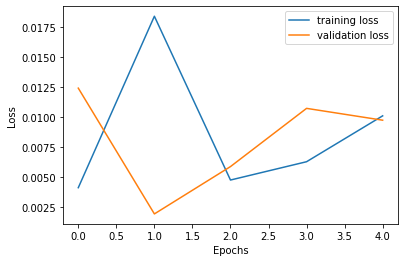

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - val_loss: 0.0124
Epoch 2/20
1/1 [==============================] - 0s 76ms/step - loss: 0.0324 - val_loss: 9.8701e-04
Epoch 3/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0038 - val_loss: 0.0070
Epoch 4/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0058 - val_loss: 0.0122
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0069


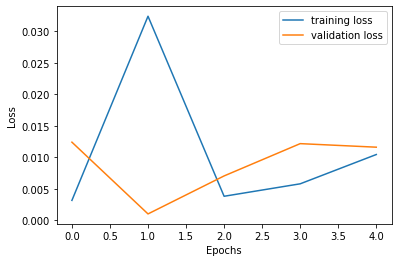

2010-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0027 - val_loss: 0.0515
Epoch 2/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0537 - val_loss: 0.0054
Epoch 3/20
1/1 [==============================] - 0s 309ms/step - loss: 0.0052 - val_loss: 0.0106
Epoch 4/20
1/1 [==============================] - 0s 94ms/step - loss: 0.0099 - val_loss: 0.0238
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0172


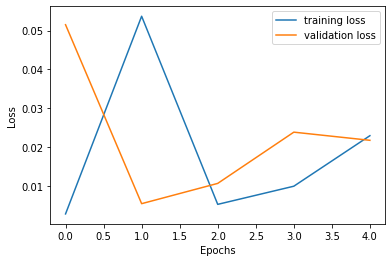

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - val_loss: 0.0090
Epoch 2/20
1/1 [==============================] - 0s 78ms/step - loss: 0.0096 - val_loss: 0.0035
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0039


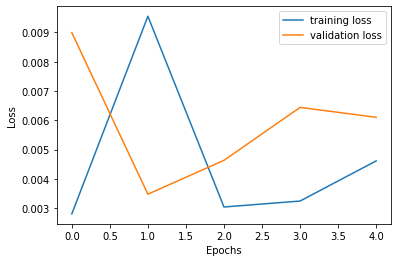

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0024 - val_loss: 0.0044
Epoch 2/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 4/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 5/20
1/1 [==============================] - 0s 95ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 6/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 7/20
1/1 [==============================] - 0s 76ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0014


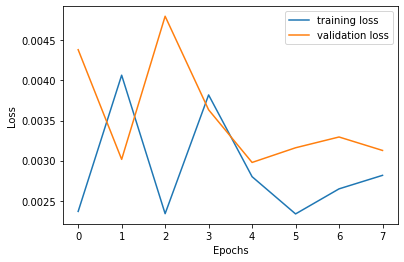

2011-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0021 - val_loss: 0.2184
Epoch 2/20
1/1 [==============================] - 0s 77ms/step - loss: 0.2343 - val_loss: 0.0121
Epoch 3/20
1/1 [==============================] - 0s 75ms/step - loss: 0.0119 - val_loss: 0.0198
Epoch 4/20
1/1 [==============================] - 0s 75ms/step - loss: 0.0240 - val_loss: 0.0602
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0666


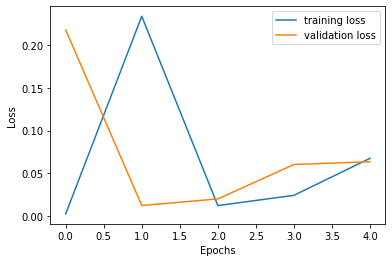

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0047 - val_loss: 0.0035
Epoch 2/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0068 - val_loss: 6.8867e-04
Epoch 3/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0039 - val_loss: 8.4897e-04
Epoch 4/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 5/20
1/1 [==============================] - 0s 20ms/step - loss: 0.0043


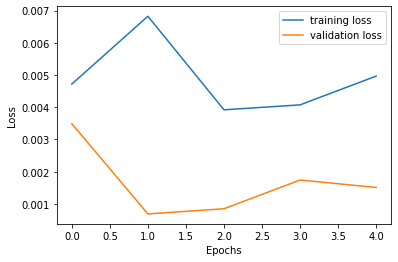

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0022 - val_loss: 0.0080
Epoch 2/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0080 - val_loss: 0.0015
Epoch 3/20
1/1 [==============================] - 0s 76ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/20
1/1 [==============================] - 0s 305ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 5/20
1/1 [==============================] - 0s 94ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 6/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 7/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0030 - val_loss: 8.3973e-04
Epoch 8/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 9/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 10/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0023


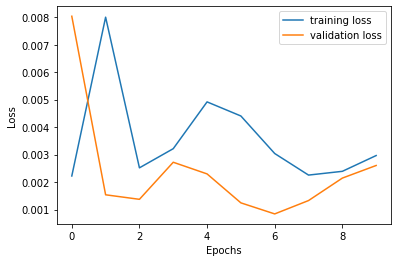

2012-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0012 - val_loss: 0.0123
Epoch 2/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0117 - val_loss: 0.0016
Epoch 3/20
1/1 [==============================] - 0s 308ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0040


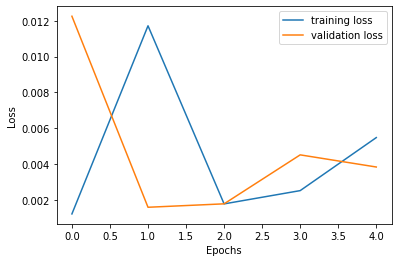

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0027 - val_loss: 0.0141
Epoch 2/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0157 - val_loss: 0.0011
Epoch 3/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 4/20
1/1 [==============================] - 0s 97ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0041


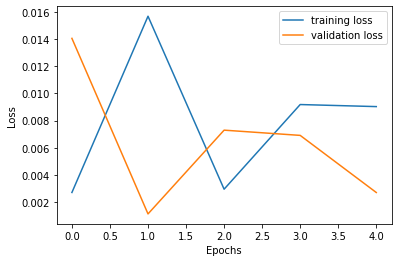

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0029 - val_loss: 0.3846
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 0.3652 - val_loss: 0.0253
Epoch 3/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0232 - val_loss: 0.0359
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0386 - val_loss: 0.1207
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.1233


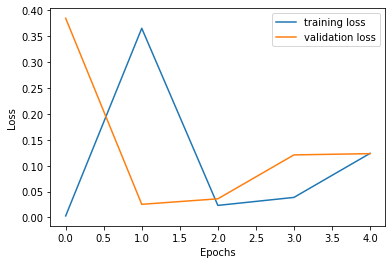

2013-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0016 - val_loss: 0.0275
Epoch 2/20
1/1 [==============================] - 0s 90ms/step - loss: 0.0202 - val_loss: 0.0033
Epoch 3/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 4/20
1/1 [==============================] - 0s 89ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 5/20
1/1 [==============================] - 0s 97ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0027


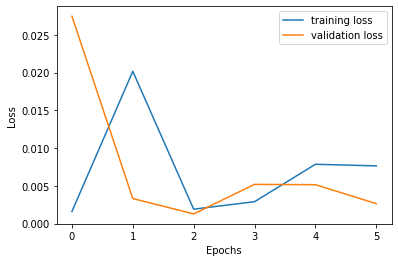

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0030 - val_loss: 0.0266
Epoch 2/20
1/1 [==============================] - 0s 307ms/step - loss: 0.0237 - val_loss: 0.0033
Epoch 3/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 4/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0041 - val_loss: 0.0099
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0073


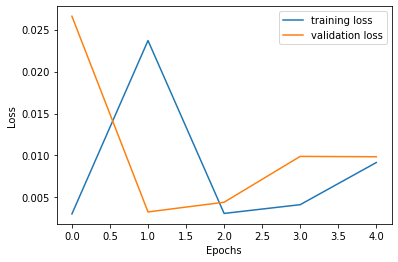

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0100 - val_loss: 0.0322
Epoch 2/20
1/1 [==============================] - 0s 93ms/step - loss: 0.0380 - val_loss: 0.0013
Epoch 3/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 4/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0043 - val_loss: 0.0130
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0138


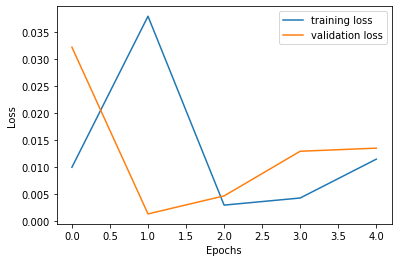

2014-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 6.3575e-04 - val_loss: 0.0163
Epoch 2/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0169 - val_loss: 0.0013
Epoch 3/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 0.0035 - val_loss: 0.0082
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0042


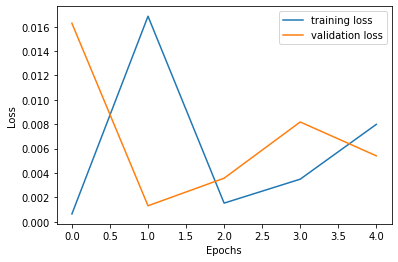

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0020 - val_loss: 0.0026
Epoch 2/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0032 - val_loss: 4.6792e-04
Epoch 3/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0019 - val_loss: 1.6311e-04
Epoch 4/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0024 - val_loss: 5.0895e-04
Epoch 5/20
1/1 [==============================] - 0s 91ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0037


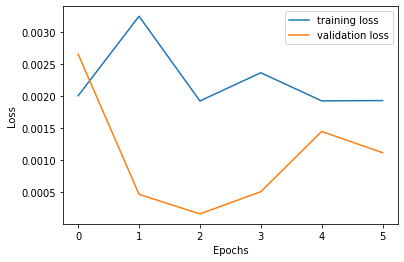

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 4.5889e-04 - val_loss: 0.1355
Epoch 2/20
1/1 [==============================] - 0s 303ms/step - loss: 0.1230 - val_loss: 0.0090
Epoch 3/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0062 - val_loss: 0.0133
Epoch 4/20
1/1 [==============================] - 0s 97ms/step - loss: 0.0176 - val_loss: 0.0411
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0392


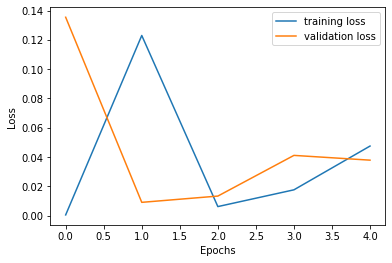

2015-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 4.4862e-04 - val_loss: 0.0087
Epoch 2/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0090 - val_loss: 6.7706e-04
Epoch 3/20
1/1 [==============================] - 0s 85ms/step - loss: 8.1898e-04 - val_loss: 0.0015
Epoch 4/20
1/1 [==============================] - 0s 85ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0059


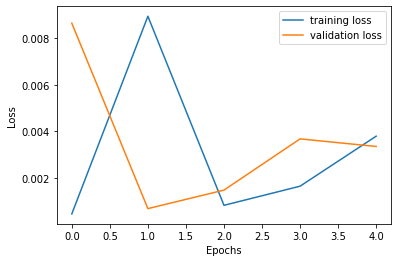

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0021 - val_loss: 0.0111
Epoch 2/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 3/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 4/20
1/1 [==============================] - 0s 83ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0029


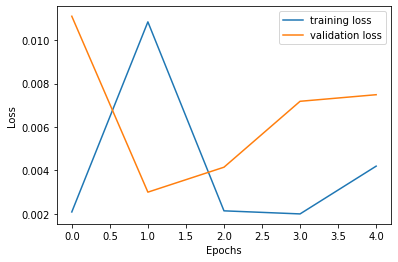

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0361 - val_loss: 0.0710
Epoch 2/20
1/1 [==============================] - 0s 92ms/step - loss: 0.0559 - val_loss: 0.0087
Epoch 3/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 4/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0027 - val_loss: 0.0091
Epoch 5/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0100 - val_loss: 0.0114
Epoch 6/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0051


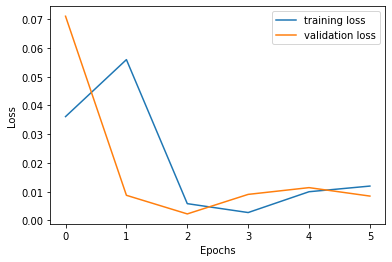

2016-05-31 00:00:00
(37, 107)
(16, 107)
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 4.8108e-04 - val_loss: 0.1424
Epoch 2/20
1/1 [==============================] - 0s 303ms/step - loss: 0.1472 - val_loss: 0.0072
Epoch 3/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0080 - val_loss: 0.0241
Epoch 4/20
1/1 [==============================] - 0s 84ms/step - loss: 0.0217 - val_loss: 0.0649
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0481


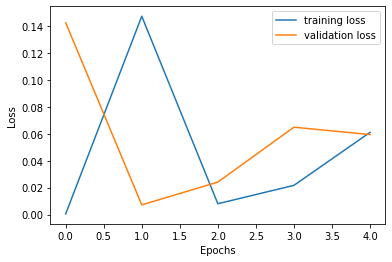

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0015 - val_loss: 0.0049
Epoch 2/20
1/1 [==============================] - 0s 94ms/step - loss: 0.0086 - val_loss: 0.0053
Epoch 3/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0020 - val_loss: 0.0121
Epoch 4/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0081


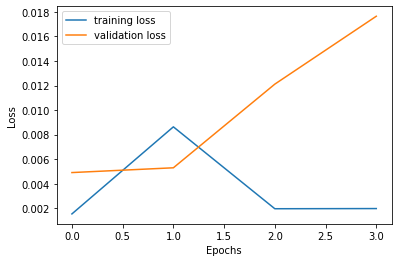

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 5.2919e-04 - val_loss: 0.0260
Epoch 2/20
1/1 [==============================] - 0s 79ms/step - loss: 0.0332 - val_loss: 6.7734e-04
Epoch 3/20
1/1 [==============================] - 0s 93ms/step - loss: 8.5535e-04 - val_loss: 0.0202
Epoch 4/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0151 - val_loss: 0.0204
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0065


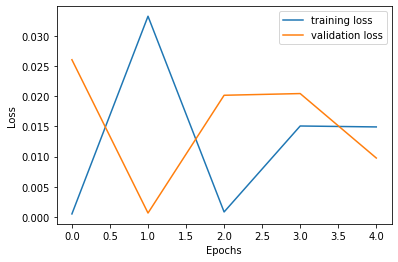

In [ ]:
# 재석
# (classify_or_regress, one_or_multi, method, X, Y, epochs,learning_rate, n_hidden, n_neurons, drop_outs, input_shape):
Total_Q_df,Total_loss_df = main("regress", "one","RNN", X, Y, 20, 0.05, 5, 1, 0.5, 107)

In [ ]:
Total_Q_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/RNN_Q_df.csv')

In [ ]:
Total_Q_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/RNN_Q_df.csv', index_col = 0)

In [ ]:
Total_Q_df.index = pd.to_datetime(Total_Q_df.index)

In [ ]:
Total_Q_df = Total_Q_df / 1.5

In [ ]:
Total_Q_df_tmp

,kospi-kosdaq,kospi-bond,kosdaq-bond
2004-05-31,-0.031658,-0.057679,-0.026021
2004-06-30,-0.035916,-0.060592,-0.024677
2004-07-31,-0.042718,-0.068541,-0.025823
2004-08-31,-0.027575,-0.052364,-0.024789
2004-09-30,-0.039799,-0.064708,-0.024910
...,...,...,...
2020-01-31,-0.022071,0.096767,0.118838
2020-02-29,-0.021975,0.096790,0.118765
2020-03-31,-0.022178,0.096875,0.119053
2020-04-30,-0.022158,0.096788,0.118946


In [ ]:
asset_li = Total_Q_df.columns.tolist()
test_date_list = Total_Q_df.index.tolist()
final_backtest_ =  final_backtest(Total_Q_df, mkt_data)

In [ ]:
final_backtest_[0].to_csv('/content/drive/MyDrive/Colab Notebooks/data/RNN_cum_ret.csv')

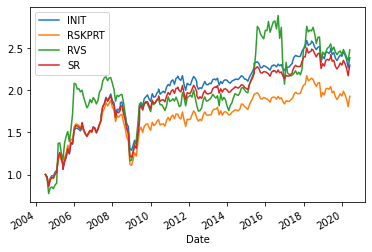

In [ ]:
final_backtest_[0].plot()